# Data Efficient Spectral StyleDCGAN  

> Aryan Garg   

## Imports

#### wandb

In [1]:
!pip -Uqq install wandb pytorch-lightning torchmetrics

import wandb
from pytorch_lightning.loggers import WandbLogger

wandb.login()

# API Key:
# d926baa25b6a14ffa4e5c30a6f3bbffbeca8fcf1


Usage:   
  pip <command> [options]

no such option: -U


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

#### Pytorch-Lightning (Don't open... very large installation output)

In [2]:
try:
  import lightning.pytorch as pl
except:
  print("[!] Couldn't find pytorch-lightning.\nInstalling it...\n")
  !pip install lightning
  import pytorch_lightning as pl

[!] Couldn't find pytorch-lightning.
Installing it...



In [3]:
from pytorch_lightning.utilities.model_summary import ModelSummary

In [4]:
from pytorch_lightning import seed_everything

#### Standard imports

In [5]:
import os
import shutil
import pathlib

from PIL import Image
import numpy as np
import cv2 as cv
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset

import torchvision
from torchvision import datasets

In [6]:
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Resize

##### Albumentations 

In [7]:
try:
  import albumentations as A
  from albumentations.pytorch import ToTensorV2
except:
  print("[!] Couldn't find albumentations... installing it.")
  !pip install -Uqq albumentations
  import albumentations as A
  from albumentations.pytorch import ToTensorV2

##### Torchmetrics

In [8]:
try:
  import torchmetrics
except:
  print(f"[!] Torchmetrics couldn't be imported.\nInstalling...")
  !pip install torchmetrics
  import torchmetrics

## Custom Utilities

In [9]:
# Folder Utilities ----------------------------

## Create dir if it doesn't exist
def create_dir(dir_name):
  if not os.path.exists(f'/content/{dir_name}'):
    os.mkdir(f'/content/{dir_name}')

## Delete dir: checkpoints
def delete_dir(dir_name):
  if os.path.isdir(f'/content/{dir_name}'):
    shutil.rmtree(f'/content/{dir_name}')

# ---------------------------------------------

## Transforms

In [10]:
# TODO: For experiments later on!
# train_transform = A.Compose(
#     [
#         A.SmallestMaxSize(max_size=160),
#         A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
#         A.RandomCrop(height=128, width=128),
#         A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
#         A.RandomBrightnessContrast(p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
#         ToTensorV2(),
#     ]
# )

## Dataset

### Download and set-up dir structure

In [11]:
# !mkdir -p ./data
# !wget -O ./data/afhq.zip -N https://www.dropbox.com/s/t9l9o3vsx2jai3z/afhq.zip?dl=0 
# !unzip ./data/afhq.zip -d ./data
# !rm ./data/afhq.zip

In [12]:
# ! rm -rf ./data/afhq/train/cat ./data/afhq/train/wild ./data/afhq/val/cat ./data/afhq/val/wild 

### Dataset & DataLoader

In [13]:
# Log this config file to wandb
CONFIG = dict(
    seed=42,
    DATA_ROOT = './data/afhq/',
    BATCH_SIZE = 16,
    WORKERS = 8,
    IMG_SIZE = (256,256),
    NUM_EPOCHS = 100,
    lr = 0.0005,
    b1 = 0.9,
    b2 = 0.999,
    nc = 3,   # Number of channels in images.
    nz = 128, # Latent vector size
    ngf = 128, # Size of feature maps in G
    ndf = 8,  # Size of feature maps in D
    disc_steps=1,
    checkpoint_path='./checkpoints/',
    min_lr=0.0001
    )

In [14]:
seed_everything(CONFIG['seed'])

Global seed set to 42


42

In [15]:
# device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

In [16]:
class DogsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.files = os.listdir(root)

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        file = self.files[index]
        img = Image.open(os.path.join(self.root, file))
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, 1.0 

In [17]:
afhq_train_dataset = DogsDataset(root=CONFIG['DATA_ROOT']+'train/dog', 
                                          transform=Compose([Resize(CONFIG['IMG_SIZE']),
                                                             ToTensor()])
                                          )

afhq_val_dataset = DogsDataset(root=CONFIG['DATA_ROOT']+'val/dog',
                                        transform=Compose([Resize(CONFIG['IMG_SIZE']),
                                                           ToTensor()])
                                        )

In [18]:
train_dataloader = DataLoader(afhq_train_dataset, 
                              batch_size=CONFIG['BATCH_SIZE'], 
                              shuffle=True)
val_dataloader = DataLoader(afhq_val_dataset, 
                             batch_size=CONFIG['BATCH_SIZE'], 
                             shuffle=False)

In [19]:
print(len(train_dataloader), len(val_dataloader))

297 32


## Sanity Visualizations

#### Re-run this cell ↓ to generate a new grid everytime

<Figure size 800x600 with 0 Axes>

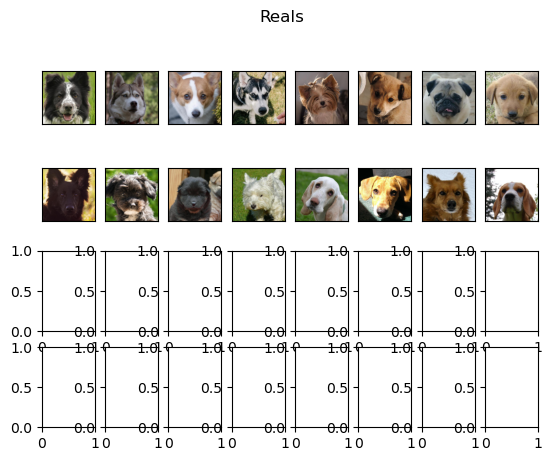

In [20]:
batch, _ = next(iter(train_dataloader))

imgs = []
for id, img in enumerate(batch):
  imgs.append(np.array(img.permute(1,2,0)))
  
fig = plt.figure(figsize=(8,6))
fig, axs = plt.subplots(4,8)
for i, img in enumerate(imgs):
  col = i % 8
  axs[i//8, col].imshow(img)
  axs[i//8, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.suptitle("Reals")
plt.show()

## Model Arch. 


### Generator

In [21]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    nz = CONFIG['nz']
    ngf = CONFIG['ngf']
    nc = CONFIG['nc']

    self.model = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        # state size. ``(ngf*8) x 4 x 4``
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        # state size. ``(ngf*4) x 8 x 8``
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),

        # state size. ``(ngf*2) x 16 x 16``
        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # state size. ``(ngf) x 32 x 32``
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. ``(nc) x 64 x 64``
      )

  def forward(self, input):
    return self.model(input)

In [22]:
from torchvision import models
from torchsummary import summary

In [23]:
g = Generator() #.to(device)
# summary(g, (128, 1, 1))

### Discriminator

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        nc = CONFIG['nc']
        ndf= CONFIG['ndf']

        # TODO: Add drop-out layer for another experiment

        self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 16, ndf * 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 32),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 32, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        y = self.model(input)
        # print("Disc:", y.shape)
        return y

In [25]:
d = Discriminator().to(device)
summary(d, (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             384
         LeakyReLU-2          [-1, 8, 128, 128]               0
            Conv2d-3           [-1, 16, 64, 64]           2,048
       BatchNorm2d-4           [-1, 16, 64, 64]              32
         LeakyReLU-5           [-1, 16, 64, 64]               0
            Conv2d-6           [-1, 32, 32, 32]           8,192
       BatchNorm2d-7           [-1, 32, 32, 32]              64
         LeakyReLU-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          32,768
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        LeakyReLU-11           [-1, 64, 16, 16]               0
           Conv2d-12            [-1, 128, 8, 8]         131,072
      BatchNorm2d-13            [-1, 128, 8, 8]             256
        LeakyReLU-14            [-1, 12

### Spectral Discriminator

It is important note that spectral norm does not eliminate the need for batch norm. Spectral norm affects the weights of each layer, while batch norm affects the activations of each layer.

In [26]:
class Spectral_Discriminator(nn.Module):
  """
  Claim:
    Spectral Norm stabilizes training
  
  Support:
    https://arxiv.org/abs/1802.05957
  """
  def __init__(self):
    super(Spectral_Discriminator, self).__init__()

    nc = CONFIG['nc']
    ndf= CONFIG['ndf']
    
    self.model = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
  def forward(self, input):
    return self.model(input)

In [27]:
torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms(False)

In [28]:
spd = Spectral_Discriminator() #.to(device)
# summary(spd, (3,256,256))

### Gen+Mapping+AdaIN

In [29]:
class MappingNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    nz = CONFIG['nz']

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(nz,nz)
    self.act = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self, z):
    z = F.normalize(z, dim=1)
    z = self.flatten(z)
    # print(z.shape)
    z1 = self.act(self.linear(z))
    z2 = self.act(self.linear(z1))
    z3 = self.act(self.linear(z2))
    w = self.act(self.linear(z3))
    
    # To sample ws for W-space exploration
    # print("w:", w)
    # print("w:", w.shape)
    return w

In [30]:
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
      super().__init__()
      self.instance_norm = nn.InstanceNorm2d(channels)
      self.style_scale   = nn.Linear(w_dim, channels)
      self.style_bias    = nn.Linear(w_dim, channels)
      self.flatten       = nn.Flatten()

    def forward(self,x,w):
      w = self.flatten(w)
      # print("x:",x.shape, "w_flatten:", w.shape)
      x = self.instance_norm(x)
      # print("after instance norm, x:",x.shape)
      
      style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
      # print("style_scale.shape:", style_scale.shape)
      style_bias  = self.style_bias(w).unsqueeze(2).unsqueeze(3)
      # print("style_bias.shape:", style_bias.shape)
      return style_scale * x + style_bias

In [31]:
class Generator_Mapper_AdaIN(nn.Module):
    def __init__(self):
        super(Generator_Mapper_AdaIN, self).__init__()

        nz = CONFIG['nz']
        ngf = CONFIG['ngf']
        nc = CONFIG['nc']

        self.starting_const = nn.Parameter(torch.randn(1, nz, 1, 1))

        self.mapper = MappingNetwork()
        self.act = nn.ReLU(inplace=True)

        # L1
        # state size. ``(ngf*8) x 4 x 4``
        self.conv_l1 = nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False)
        self.ada_l1 = AdaIN(ngf * 8, nz)
      
        # L2
        # state size. ``(ngf*4) x 8 x 8``
        self.conv_l2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.ada_l2 = AdaIN(ngf * 4, nz)
        
        # L3
        # state size. ``(ngf*2) x 16 x 16``
        self.conv_l3 = nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.ada_l3 = AdaIN(ngf * 2, nz)
           
        # L4
        # state size. ``(ngf) x 32 x 32``
        self.conv_l4 = nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False)
        self.ada_l4 = AdaIN(ngf, nz)
        
        # L5
        # state size. ``(ngf/2) x 64 x 64``
        self.conv_l5 = nn.ConvTranspose2d( ngf, ngf//2, 4, 2, 1, bias=False)
        self.ada_l5 = AdaIN(ngf//2, nz)

        # L6
        # state size. ``(ngf/4) x 128 x 128``
        self.conv_l6 = nn.ConvTranspose2d( ngf//2, ngf//4, 4, 2, 1, bias=False)
        self.ada_l6 = AdaIN(ngf//4, nz)

        # L7
        # state size. ``(nc) x 256 x 256``
        self.conv_l7 = nn.ConvTranspose2d( ngf//4, nc, 4, 2, 1, bias=False)
        self.ada_l7 = AdaIN(nc, nz)

        self.last_layer_act = nn.Tanh()
            
      
    def forward(self, input_noise):
      w = self.mapper(input_noise)
      w = w[:, :, None, None]
    #   print(f"Gen w: {w.shape}")
      x = self.act(self.ada_l1(self.conv_l1(self.starting_const), w))
    #   print(x.shape)
      x = self.act(self.ada_l2(self.conv_l2(x), w))
    #   print(x.shape)
      x = self.act(self.ada_l3(self.conv_l3(x), w))
    #   print(x.shape)
      x = self.act(self.ada_l4(self.conv_l4(x), w))
    #   print(x.shape)
      x = self.act(self.ada_l5(self.conv_l5(x), w))
    #   print(x.shape)
      x = self.act(self.ada_l6(self.conv_l6(x), w))
    #   print(x.shape)
      x = self.last_layer_act(self.ada_l7(self.conv_l7(x), w))
    #   print("Gen out:", x.shape)
      return x

In [32]:
g_map_ada = Generator_Mapper_AdaIN().to(device)
summary(g_map_ada, (128,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 128]               0
            Linear-2                  [-1, 128]          16,512
         LeakyReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
         LeakyReLU-5                  [-1, 128]               0
            Linear-6                  [-1, 128]          16,512
         LeakyReLU-7                  [-1, 128]               0
            Linear-8                  [-1, 128]          16,512
         LeakyReLU-9                  [-1, 128]               0
   MappingNetwork-10                  [-1, 128]               0
  ConvTranspose2d-11           [-1, 1024, 4, 4]       2,097,152
          Flatten-12                  [-1, 128]               0
   InstanceNorm2d-13           [-1, 1024, 4, 4]               0
           Linear-14                 [-

## Lightning Recipe for training & testing

In [33]:
class LIT_DCGAN(pl.LightningModule):
  
  def __init__(self, 
               discriminator_model, 
               generator_model, 
               latent_dim: int = 128, 
               lr: float = 0.003, 
               b1: float = 0.5, 
               b2: float = 0.999,
               disc_steps: int = 1):
    
    super().__init__()
    self.save_hyperparameters(ignore=[discriminator_model, generator_model])
    self.automatic_optimization = False

    self.discriminator = discriminator_model
    self.generator = generator_model
  
    self.validation_z = torch.randn(8, self.hparams.latent_dim)
  
  
  def configure_optimizers(self):
    lr = self.hparams.lr
    b1 = self.hparams.b1
    b2 = self.hparams.b2

    #---------------------------
    # Exp-2-3.1
    # optim_g = torch.optim.RMSprop(self.generator.parameters(), lr=lr)
    # optim_d = torch.optim.RMSprop(self.discriminator.parameters(), lr=lr)

    # # Exp-2-3.2
    # optim_g = torch.optim.SGD(self.generator.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optim_d = torch.optim.SGD(self.discriminator.parameters(), lr=lr, momentum=0.9, nesterov=True)

    # # Exp-2-3.3
    # optim_g = torch.optim.SGD(self.generator.parameters(), lr=lr, nesterov=False)
    # optim_d = torch.optim.SGD(self.discriminator.parameters(), lr=lr, nesterov=False)

    #----------------------------

    optim_g = torch.optim.AdamW(self.generator.parameters(), lr=lr, betas=(b1,b2))
    optim_d = torch.optim.AdamW(self.discriminator.parameters(), lr=lr, betas=(b1,b2))
    
    # sch_g = torch.optim.lr_scheduler.CosineAnnealingLR(optim_g, 
    # T_max=CONFIG['NUM_EPOCHS']*len(train_dataloader)/CONFIG['BATCH_SIZE], 
    #  eta_min=CONFIG['min_lr'])

    # sch_d = torch.optim.lr_scheduler.CosineAnnealingLR(optim_d, 
    # T_max=CONFIG['NUM_EPOCHS']*len(train_dataloader)/CONFIG['BATCH_SIZE], 
    #  eta_min=CONFIG['min_lr'])
    #---------------------------

    # return [optim_g, optim_d], [sch_g, sch_d]
    return [optim_g, optim_d], []


  def forward(self, z):
    return self.generator(z)


  def adv_loss(self, prob, target):
    loss = F.binary_cross_entropy(prob.to(device), target.to(device))
    return loss


  def linear_interpolate(self, code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)
  

  # def test_step(self, batch, batch_idx): # Use for Exploring the latent space 
  #   imgs, _ = batch
  #   z1 = torch.randn(1, self.hparams.latent_dim, 1, 1) # 1 x Z_d x 1 x 1
  #   z1 = z1.type_as(imgs)

  #   z2 = torch.randn(1, self.hparams.latent_dim, 1, 1) # 1 x Z_d x 1 x 1
  #   z2 = z2.type_as(imgs)

  #   interp_imgs = []
  #   for i in tqdm(range(1001)):
  #     alpha = i/1000.
  #     z_interp = self.linear_interpolate(z1, z2, alpha)
  #     gen_img = self.generator(z_interp)
  #     interp_imgs.append(gen_img)

  #     save_img = gen_img.cpu().squeeze(0).numpy()
  #     save_img_hwc = np.reshape(save_img, (64,64,3))
  #     status = cv.imwrite(f"/content/interp/z_{i+1}.png", save_img_hwc)
  #     # print(status, save_img_hwc.shape)
      
  #   # for i in range(len(gen_img)):
  #   #   wandb_logger.log_image(key="Interpolation", 
  #   #                          images=[gen_img[i]])

  #   # self.logger.experiment.log({f"Gen_Image {alpha}":[wandb.Image(gen_img.cpu(), caption=f"Interpolation [alpha={alpha}]")]})

  #   return z1, z2, interp_imgs


  def validation_step(self, batch, batch_idx):
    imgs, _ = batch
      
    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs)
    fake_imgs = self.generator(z)
    
    real_arr = torch.ones(imgs.size(0), 1, 1, 1).to(device)
    fake_arr = torch.zeros(imgs.size(0), 1, 1, 1).to(device)

    g_loss = self.adv_loss(self.discriminator(fake_imgs), real_arr) # make fakes as close to reals

    real_D_outs = self.discriminator(imgs)
    fake_D_outs = self.discriminator(fake_imgs)
    d_loss = (self.adv_loss(real_D_outs, real_arr) + self.adv_loss(fake_D_outs, fake_arr)) / 2

    # Disc Acc:
    correct_real = sum(i > 0.5 for i in real_D_outs)
    total_real = len(real_D_outs)

    correct_fake = sum(i < 0.5 for i in fake_D_outs)
    total_fake = len(fake_D_outs)

    D_accuracy = (correct_real + correct_fake) / (total_real + total_fake)

    logs = {'val_g_loss': g_loss, 'val_d_loss': d_loss}
    self.log_dict({'val_g_loss': g_loss, 'val_d_loss': d_loss, 'val_d_accuracy': D_accuracy}, 
                  on_step=True, 
                  on_epoch=True, 
                  prog_bar=True, 
                  logger=True)
    
    cpu_fake_imgs = fake_imgs.detach().cpu().numpy()
    gen_1_id = np.random.randint(0,cpu_fake_imgs.shape[0])

    if batch_idx % 20 == 0:
      self.logger.experiment.log({"Gen_Images (val)":[wandb.Image(fake_imgs[gen_1_id].cpu(), caption="Generated 1 (val_step)")]})


  def training_step(self, batch, batch_idx):
    imgs, _ = batch
    # print(f"{batch_idx}:: imgs.shape =",imgs.shape)

    opt_g, opt_d = self.optimizers()
    # sch_g, sch_d = self.lr_schedulers()

    z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1) # N x Z_d x 1 x 1
    z = z.type_as(imgs)
    # print(z.shape)
    fake_arr = torch.zeros(imgs.size(0), 1, 1, 1).to(device) # N: 0s
    real_arr = torch.ones(imgs.size(0), 1, 1, 1).to(device) # N: 1s
    # print(f"Disc out shape:", self.discriminator(self(z)).shape)
    # Train G:
    self.toggle_optimizer(opt_g)
    
    # Generator loss:
    fake_imgs = self.generator(z)
    g_loss = self.adv_loss(self.discriminator(fake_imgs), real_arr) # Fooling the Disc: How Real is the fake output?

    # Grad step:
    # self.log("g_loss", g_loss, prog_bar=True)
    self.manual_backward(g_loss)
    opt_g.step()
    opt_g.zero_grad()

    # Scheduler moves ahead after every epoch
    # if (batch_idx + 1) % CONFIG['BATCH_SIZE'] == 0: 
    #     sch_g.step()
        
    self.untoggle_optimizer(opt_g)

    # Train Discriminator
    self.toggle_optimizer(opt_d)

    # Experimental evidence: #disc_steps is kept to 1
    
    for i in range(self.hparams.disc_steps):
      # Discriminator loss:
      real_D_outs = self.discriminator(imgs)
      d_loss_real = self.adv_loss(real_D_outs, real_arr)

      fake_D_outs = self.discriminator(self.generator(z))
      d_loss_fake = self.adv_loss(fake_D_outs, fake_arr)

      d_loss = (d_loss_fake + d_loss_real) / 2

      # self.log("d_loss", d_loss, prog_bar=True)
      self.manual_backward(d_loss)
      opt_d.step()
      opt_d.zero_grad()

      # Disc Acc:
      correct_real = sum(i > 0.5 for i in real_D_outs)
      total_real = len(real_D_outs)

      correct_fake = sum(i < 0.5 for i in fake_D_outs)
      total_fake = len(fake_D_outs)

      D_accuracy = (correct_real + correct_fake) / (total_real + total_fake)

      # self.log("d_acc", D_accuracy, prog_bar=True)
    
    # Scheduler moves ahead after every epoch
    # if (batch_idx + 1) % CONFIG['BATCH_SIZE'] == 0: 
    #   sch_d.step()

    self.untoggle_optimizer(opt_d)

    cpu_fake_imgs = fake_imgs.detach().cpu().numpy()
    gen_id = np.random.randint(0,cpu_fake_imgs.shape[0])

    # self.logger.experiment.log({"Gen_Image_1 (during training)":[wandb.Image(fake_imgs[gen_id].cpu(), caption="Generated (train_step)")]})

    self.log_dict({"g_loss": g_loss, "d_loss": d_loss, "d_acc": D_accuracy}, 
                  on_step=True, 
                  on_epoch=True, 
                  prog_bar=True, 
                  logger=True)

    # def on_epoch_end(self):
    #   z = self.validation_z.to(self.device)

    #   # log sampled images
    #   sample_imgs = self.generator(z)
    #   grid = torchvision.utils.make_grid(sample_imgs)
    #   self.logger.experiment.add_image(f'Unseen generated imgs after epoch {self.current_epoch}:', grid, self.current_epoch)


In [34]:
sample_img, sample_target = next(iter(train_dataloader))
sample_img.shape, sample_target.size()

(torch.Size([16, 3, 256, 256]), torch.Size([16]))

In [35]:
dcgan = LIT_DCGAN(
      discriminator_model = Discriminator(), 
      generator_model = Generator_Mapper_AdaIN(), 
      latent_dim = CONFIG['nz'],
      lr=CONFIG['lr'],
      b1=CONFIG['b1'],
      b2=CONFIG['b2'],
      disc_steps=CONFIG['disc_steps']
    )
summary = ModelSummary(dcgan, max_depth=-1)
print(summary)

   | Name                           | Type                   | Params
---------------------------------------------------------------------------
0  | discriminator                  | Discriminator          | 703 K 
1  | discriminator.model            | Sequential             | 703 K 
2  | discriminator.model.0          | Conv2d                 | 384   
3  | discriminator.model.1          | LeakyReLU              | 0     
4  | discriminator.model.2          | Conv2d                 | 2.0 K 
5  | discriminator.model.3          | BatchNorm2d            | 32    
6  | discriminator.model.4          | LeakyReLU              | 0     
7  | discriminator.model.5          | Conv2d                 | 8.2 K 
8  | discriminator.model.6          | BatchNorm2d            | 64    
9  | discriminator.model.7          | LeakyReLU              | 0     
10 | discriminator.model.8          | Conv2d                 | 32.8 K
11 | discriminator.model.9          | BatchNorm2d            | 128   
12 | discrimin

/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'discriminator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator_model'])`.
  rank_zero_warn(
/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'generator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_model'])`.
  rank_zero_warn(


## Trainer (+ callbacks)

In [36]:
from pytorch_lightning import Callback
from pytorch_lightning.callbacks import TQDMProgressBar, ModelCheckpoint, EarlyStopping, LearningRateMonitor

# Checkpoint
checkpoint_callback = ModelCheckpoint(dirpath=CONFIG['checkpoint_path'],
                                      filename='{epoch}-{val_g_loss:.3f}',
                                      monitor='val_g_loss',
                                      save_top_k=-1,
                                      save_last=True,
                                      save_weights_only=True,
                                      verbose=True,
                                      mode='min')

# Exp2: Learning Rate Monitor
lr_monitor = LearningRateMonitor(logging_interval='step', log_momentum=True)

# Earlystopping
# earlystopping = EarlyStopping(monitor='val_d_acc', patience=3, mode='min')

In [37]:
wandb_logger = WandbLogger(project='iclr2_SDG', 
                           name='eps_100',
                           config=CONFIG,
                           job_type='train_val',
                           log_model="all")

In [ ]:
# train model
trainer = pl.Trainer(fast_dev_run=False,    # For debugging purposes
                     log_every_n_steps=5,   # set the logging frequency
                     accelerator='gpu',    # Precedence: tpu > gpu >> cpu
                     devices=1,        # all
                     max_epochs=CONFIG['NUM_EPOCHS'], # number of epochs
                     callbacks=[TQDMProgressBar(refresh_rate=25), 
                                checkpoint_callback, 
                                lr_monitor],
                     logger=wandb_logger,    # wandb <3
                     )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Training & Validation

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
# Train model:
trainer.fit(dcgan, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type                   | Params
---------------------------------------------------------
0 | discriminator | Discriminator          | 703 K 
1 | generator     | Generator_Mapper_AdaIN | 13.8 M
---------------------------------------------------------
14.5 M    Trainable params
0         Non-trainable params
14.5 M    Total params
58.056    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

wandb: ERROR Error while calling W&B API: run lfvr/DESSDCGAN/rdgmqsn9 was previously created and deleted; try a new run name (<Response [409]>)
Thread SenderThread:
Traceback (most recent call last):
  File "/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/wandb/apis/normalize.py", line 41, in wrapper
    return func(*args, **kwargs)
  File "/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/wandb/sdk/internal/internal_api.py", line 1825, in upsert_run
    response = self.gql(
  File "/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/wandb/sdk/internal/internal_api.py", line 294, in gql
    ret = self._retry_gql(
  File "/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/wandb/sdk/lib/retry.py", line 131, in __call__
    result = self._call_fn(*args, **kwargs)
  File "/home/girish/miniconda3/envs/minerva/lib/python3.9/site-packages/wandb/sdk/internal/internal_api.py", line 322, in execute
    return self.client.execute(*args, *

BrokenPipeError: [Errno 32] Broken pipe

Error in callback <function _WandbInit._pause_backend at 0x7f17301ea820> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
wandb.finish()

d_acc_epoch,█▅▄▁▄▄▄▄▄▃▅▂▃▃▁▁▁▄▄▃
d_acc_step,▅█▅▇▄▅▆▁▅▆█▆▆▇▅▇█▃▇▆▄▅▃▃▄▆▆▇▅▇▄▆▃▅▇▆▅▇▆▃
d_loss_epoch,█▁▄▇▃▂▃▄▄▅▂▄▃▄▇▇▅▁▂▃
d_loss_step,▅▂▄▃▄▃▃█▄▂▁▃▃▂▃▂▂▅▂▃▆▅▅▅▅▃▃▂▅▂▄▃▄▅▂▂▄▂▃▅
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
g_loss_epoch,█▃▃▃▂▃▃▃▃▂▃▂▂▂▁▁▁▂▂▁
g_loss_step,█▃▅▂▃▃▃▃▄▄▃▄▅▃▃▃▄▁▂▂▄▄▂▃▂▃▂▂▃▂▂▂▁▂▂▄▂▃▂▁
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-1-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr-Adam-momentum,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## Experiment 4 / Testing

#### Loading: last checkpoint of 100 eps: Gen_Mapping_AdaIN experiment (3-2)

In [ ]:
model_interp = LIT_DCGAN.load_from_checkpoint("/content/model.ckpt", map_location=torch.device('cpu'))
summary = ModelSummary(model_interp, max_depth=-1)
print(summary)

   | Name                           | Type                   | Params
---------------------------------------------------------------------------
0  | discriminator                  | Discriminator          | 2.8 M 
1  | discriminator.model            | Sequential             | 2.8 M 
2  | discriminator.model.0          | Conv2d                 | 3.1 K 
3  | discriminator.model.1          | LeakyReLU              | 0     
4  | discriminator.model.2          | Conv2d                 | 131 K 
5  | discriminator.model.3          | BatchNorm2d            | 256   
6  | discriminator.model.4          | LeakyReLU              | 0     
7  | discriminator.model.5          | Conv2d                 | 524 K 
8  | discriminator.model.6          | BatchNorm2d            | 512   
9  | discriminator.model.7          | LeakyReLU              | 0     
10 | discriminator.model.8          | Conv2d                 | 2.1 M 
11 | discriminator.model.9          | BatchNorm2d            | 1.0 K 
12 | discrimin

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'discriminator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['discriminator_model'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'generator_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['generator_model'])`.
  rank_zero_warn(


In [ ]:
doggo = model_interp.generator(torch.randn(1,128,1,1)).squeeze()

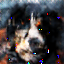

In [ ]:
pil_doggo = torchvision.transforms.ToPILImage()(doggo)
display(pil_doggo)

In [ ]:
!rm -rf interp
!mkdir interp

In [ ]:
def linear_interpolate(code1, code2, alpha):
    return code1 * alpha + code2 * (1 - alpha)

#### z-space Interpolation

In [ ]:
# trainer_interp = pl.Trainer(fast_dev_run=False,    # For debugging purposes
#                      log_every_n_steps=1,   # set the logging frequency
#                      accelerator='auto',    # Precedence: tpu > gpu >> cpu
#                      devices="auto",        # all
#                      max_epochs=CONFIG['NUM_EPOCHS'], # number of epochs
#                      deterministic=True,    # keep it deterministic
#                      callbacks=[TQDMProgressBar(refresh_rate=25), 
#                                 checkpoint_callback, 
#                                 lr_monitor],
#                      logger=wandb_logger,    # wandb <3
#                      )

# gen_imgs, z1, z2 = trainer_interp.test(model_interp, train_dataloader)

model_interp.eval()

with torch.inference_mode():
    z1 = torch.randn(1, 100, 1, 1) # 1 x Z_d x 1 x 1
    z2 = torch.randn(1, 100, 1, 1) # 1 x Z_d x 1 x 1
    # print(z1, z2)
    
    gen_img_arr = []
    for i in tqdm(range(1001)):
      alpha = i/1000.0
      z_interp = linear_interpolate(z1, z2, alpha)

      gen_img = model_interp.generator(torch.randn(1,100,1,1)).squeeze()
      pil_gen_img = torchvision.transforms.ToPILImage()(gen_img)

      gen_img_arr.append(pil_gen_img)

      num = str(i).zfill(5)
      pil_gen_img.save(f"/content/interp/z_{num}.png")

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
make_latent_interp_video(gen_img_arr)

In [ ]:
!zip -r /content/latent_interp.zip /content/interp

  adding: content/interp/ (stored 0%)
  adding: content/interp/z_00124.png (stored 0%)
  adding: content/interp/z_00977.png (stored 0%)
  adding: content/interp/z_00110.png (stored 0%)
  adding: content/interp/z_00650.png (stored 0%)
  adding: content/interp/z_00587.png (stored 0%)
  adding: content/interp/z_00451.png (stored 0%)
  adding: content/interp/z_00386.png (stored 0%)
  adding: content/interp/z_00454.png (stored 0%)
  adding: content/interp/z_00980.png (stored 0%)
  adding: content/interp/z_00282.png (stored 0%)
  adding: content/interp/z_00153.png (stored 0%)
  adding: content/interp/z_00203.png (stored 0%)
  adding: content/interp/z_00627.png (stored 0%)
  adding: content/interp/z_00726.png (stored 0%)
  adding: content/interp/z_00139.png (stored 0%)
  adding: content/interp/z_00955.png (stored 0%)
  adding: content/interp/z_00503.png (stored 0%)
  adding: content/interp/z_00434.png (stored 0%)
  adding: content/interp/z_00702.png (stored 0%)
  adding: content/interp/z_0059

#### W-space interpolation

Detach Mapper == Make the Mapper -> Identity Function

In [ ]:
model_interp.generator.mapper = nn.Identity()
model_interp.generator.act = nn.Identity()

In [ ]:
print(model_interp)

LIT_DCGAN(
  (discriminator): Discriminator(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)

In [ ]:
!rm -rf interp_wspace
!mkdir interp_wspace
!rm -rf *.gif 
!rm -rf *.zip

Same inference code as above (make it a function?)

In [ ]:
w1 = torch.Tensor([[-0.0202, -0.0682,  0.7329, -0.0784, -0.0581,  0.4230,  0.2379, -0.0833,
          0.7884,  0.2248,  0.2776, -0.0364,  0.2855,  0.7926,  1.1424,  0.2005,
         -0.1099, -0.0617, -0.0450, -0.0446,  0.5390,  0.4721,  0.3224, -0.0937,
          0.6817,  0.3990, -0.0531,  0.3876,  0.4818, -0.0865, -0.0473,  0.6816,
          0.3565, -0.1395,  0.1849,  0.5416, -0.0338, -0.0528, -0.0569, -0.0390,
         -0.0337, -0.0225, -0.0631, -0.0995, -0.1762, -0.0521, -0.0237, -0.0258,
         -0.0525, -0.1756, -0.0153, -0.0088, -0.0759,  0.2723, -0.1178, -0.0943,
         -0.0561, -0.0397, -0.0513, -0.1754,  0.0962,  0.1861, -0.0554, -0.1032,
          0.2359,  0.1748,  0.9084,  0.6256, -0.0803, -0.1207,  0.4919, -0.1091,
         -0.2582, -0.0199, -0.0550, -0.0362,  0.2747, -0.0628,  0.3789,  0.1299,
         -0.0490, -0.0707, -0.0169,  0.3357,  1.2385, -0.0504, -0.0400, -0.0192,
         -0.0951,  0.0283, -0.0648, -0.0835, -0.0373, -0.0644, -0.0554,  0.4078,
          0.8167, -0.0814,  0.3089, -0.1398]])

w1 = w1[:,:,None,None]

w2 = torch.Tensor([[-0.0815, -0.0812,  1.0785, -0.0337,  0.2382, -0.0653, -0.0843, -0.0853,
         -0.0079,  0.1121,  0.4561, -0.0434,  0.0715,  0.1232, -0.0807, -0.0287,
         -0.1417, -0.0685, -0.0447, -0.0280,  0.0060, -0.0158,  0.0893, -0.1232,
         -0.0422,  0.0831, -0.0311, -0.0249,  0.3923, -0.0615,  0.6317, -0.0238,
          1.0377,  0.7621, -0.1357, -0.0412,  0.2459, -0.0524, -0.0851, -0.0426,
         -0.0411,  0.1024,  0.1441, -0.2577, -0.3709,  0.1332,  0.4081,  0.4787,
         -0.0377, -0.1412,  0.0837, -0.1878, -0.0450,  0.6566,  0.5865,  0.2882,
         -0.2444, -0.1360,  0.0099, -0.0961, -0.0145, -0.0230, -0.0588, -0.0809,
          0.5434, -0.0609, -0.0397, -0.0355, -0.0937, -0.2652, -0.0361,  0.6187,
         -0.3286,  0.3020, -0.0316,  0.3171,  1.2937, -0.0932, -0.0545, -0.0292,
         -0.0029, -0.0697, -0.0190,  0.6632,  0.0651, -0.0311, -0.0555, -0.0942,
          0.4408, -0.0249,  0.4270, -0.0886,  0.3606, -0.0702, -0.0552, -0.0330,
          0.0201,  0.4094,  0.7881,  0.2090]])

w2 = w2[:,:,None,None]
print(w1.shape, w2.shape)

torch.Size([1, 100, 1, 1]) torch.Size([1, 100, 1, 1])


In [ ]:
# w-space interpolation

model_interp.eval()

with torch.inference_mode():
    
    gen_img_arr_wspace = []
    for i in tqdm(range(1001)):
      alpha = i/1000.0
      z_interp = linear_interpolate(w1, w2, alpha) # w1 and w2 are defined above

      gen_img = model_interp.generator(torch.randn(1,100,1,1)).squeeze()
      pil_gen_img = torchvision.transforms.ToPILImage()(gen_img)

      gen_img_arr_wspace.append(pil_gen_img)

      num = str(i).zfill(5)
      pil_gen_img.save(f"/content/interp_wspace/w_{num}.png")

  0%|          | 0/1001 [00:00<?, ?it/s]

In [ ]:
def make_latent_interp_video(gen_imgs):
  gen_imgs[0].save("out_10fps_wspace_1May.gif", save_all=True, append_images=gen_imgs, duration=100, loop=0)

In [ ]:
make_latent_interp_video(gen_img_arr_wspace)

In [ ]:
!zip -r /content/w_space_2.zip /content/interp_wspace

  adding: content/interp_wspace/ (stored 0%)
  adding: content/interp_wspace/w_00284.png (stored 0%)
  adding: content/interp_wspace/w_00975.png (stored 0%)
  adding: content/interp_wspace/w_00248.png (stored 0%)
  adding: content/interp_wspace/w_00354.png (stored 0%)
  adding: content/interp_wspace/w_00005.png (stored 0%)
  adding: content/interp_wspace/w_00172.png (stored 0%)
  adding: content/interp_wspace/w_00045.png (stored 0%)
  adding: content/interp_wspace/w_00387.png (stored 0%)
  adding: content/interp_wspace/w_00793.png (deflated 5%)
  adding: content/interp_wspace/w_00829.png (stored 0%)
  adding: content/interp_wspace/w_00351.png (stored 0%)
  adding: content/interp_wspace/w_00469.png (stored 0%)
  adding: content/interp_wspace/w_00660.png (stored 0%)
  adding: content/interp_wspace/w_00317.png (stored 0%)
  adding: content/interp_wspace/w_00115.png (stored 0%)
  adding: content/interp_wspace/w_00868.png (stored 0%)
  adding: content/interp_wspace/w_00319.png (stored 0%)
 

### Residual Connections

In [ ]:
# import required libraries
import torch
from torch import nn
import torch.nn.functional as F
import torchvision


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=[1, 1], downsample=None):
        super(ResidualBlock, self).__init__()

        pass

    def forward(self, x):
        pass